In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
from dotmap import DotMap
import pandas as pd
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'retina'

# https://www.kaggle.com/datasets/ruchi798/star-wars

In [2]:
episodes = []
factions = []
for i in range(1, 8):
    with open(f'data/interactions/starwars-episode-{i}-interactions-allCharacters.json') as f:
        episodes.append(DotMap(json.load(f)))
    try:
        with open(f'data/factions/factions_{i}.json') as f:
            factions.append(json.load(f))
    except:
        factions.append({})

outcomes = []
with open('data/outcomes.json') as f:
    outcomes = json.load(f)
    outcomes = [v for k, v in outcomes.items()]

In [3]:
name_mappings = []

for i in range(1, 8):
    with open(f'data/characters_mapping/episode_{i}.json') as f:
        name_mappings.append(DotMap(json.load(f)))

In [4]:
networks = []
for i, episode in enumerate(episodes):
    G = nx.Graph()
    to_remove = []
    for node in episode.nodes:
        if len(factions[i]) > 0:
            if node.name in factions[i]['bad']:
                faction = 'bad'
            elif node.name in factions[i]['good']:
                faction = 'good'
            elif node.name in factions[i]['neutral']:
                faction = 'neutral'
            elif node.name in factions[i]['remove']:
                to_remove.append(node.name)
            else:
                raise Exception(f'Unknown faction for {node.name}')
        # if name_mappings[i].get(node.name, '') == '':
        #     to_remove.append(node.name)
        G.add_node(node.name, value=node.value, color=node.colour, faction=faction)
    for link in episode.links:
        G.add_edge((nl:=list(G.nodes))[link.source], nl[link.target], weight=link.value)
    for node in to_remove:
        if node in G.nodes:
            G.remove_node(node)
    G = nx.subgraph(G, max(nx.connected_components(G), key=len))
    networks.append(G)
    print(to_remove)

['PK-4']
['PK-4']
[]
[]
[]
[]
[]


In [5]:
faction_to_color = {
    'bad' : 'tab:red',
    'good' : 'tab:blue',
    'neutral' : 'tab:green',
}

In [6]:
stats = pd.DataFrame(columns=['episode'])
stats.set_index('episode', inplace=True)

def get_stats(G):
    return {
        'nodes': len(G.nodes),
        'edges': len(G.edges),
        'density': nx.density(G),
        'avg_degree': np.mean([degree for node, degree in G.degree]),
        'connectivity': nx.average_node_connectivity(G),
        'diameter': nx.diameter(G),
        'assortativity': nx.degree_pearson_correlation_coefficient(G),
        'efficiency': nx.global_efficiency(G),
        'avg_betweenness_centrality': np.mean([nx.betweenness_centrality(G)[node] for node in G.nodes]),
        'avg_closeness_centrality': np.mean([nx.closeness_centrality(G)[node] for node in G.nodes]),
        'avg_second_order_degree_centrality': np.mean([nx.second_order_centrality(G)[node] for node in G.nodes]),
        'cliques': nx.graph_number_of_cliques(G),
        'avg_clustering': nx.average_clustering(G),
        'mean_rich_club_coefficient': np.mean([v for d, v in nx.rich_club_coefficient(G, normalized=False).items()]),
        'avg_shortest_path_length': nx.average_shortest_path_length(G),
    }

for i, G in enumerate(networks):
    stats.loc[i+1, 'outcome'] = outcomes[i]
    
    for stat, value in get_stats(G).items():
        stats.loc[i+1, f'{stat}'] = value
    
    # Reorganize the columns such that the same stats are next to each other
    stats = stats.reindex(columns=['outcome'] + sorted([c for c in stats.columns if not c == 'outcome'], key=lambda x: '_'.join(x.split('_')[1:])))

    # Replace all NaNs with 0
    stats = stats.fillna(0)

# stats.to_csv('stats.csv')

/Users/mike/.pyenv/versions/3.10.2/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/var/folders/l_/vnq08k4n0hn498fyp2mcvcsm0000gn/T/ipykernel_43932/2573410491.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names, rotation=90)


      outcome  prediction  confidence
Ep 1        1           1    0.999660
Ep 2        1           1    0.991870
Ep 3        0           0    0.989440
Ep 4        1           1    0.999994
Ep 5        0           0    0.999337
Ep 6        1           1    0.990586
Ep 7        1           1    1.000000
Score: 1.0


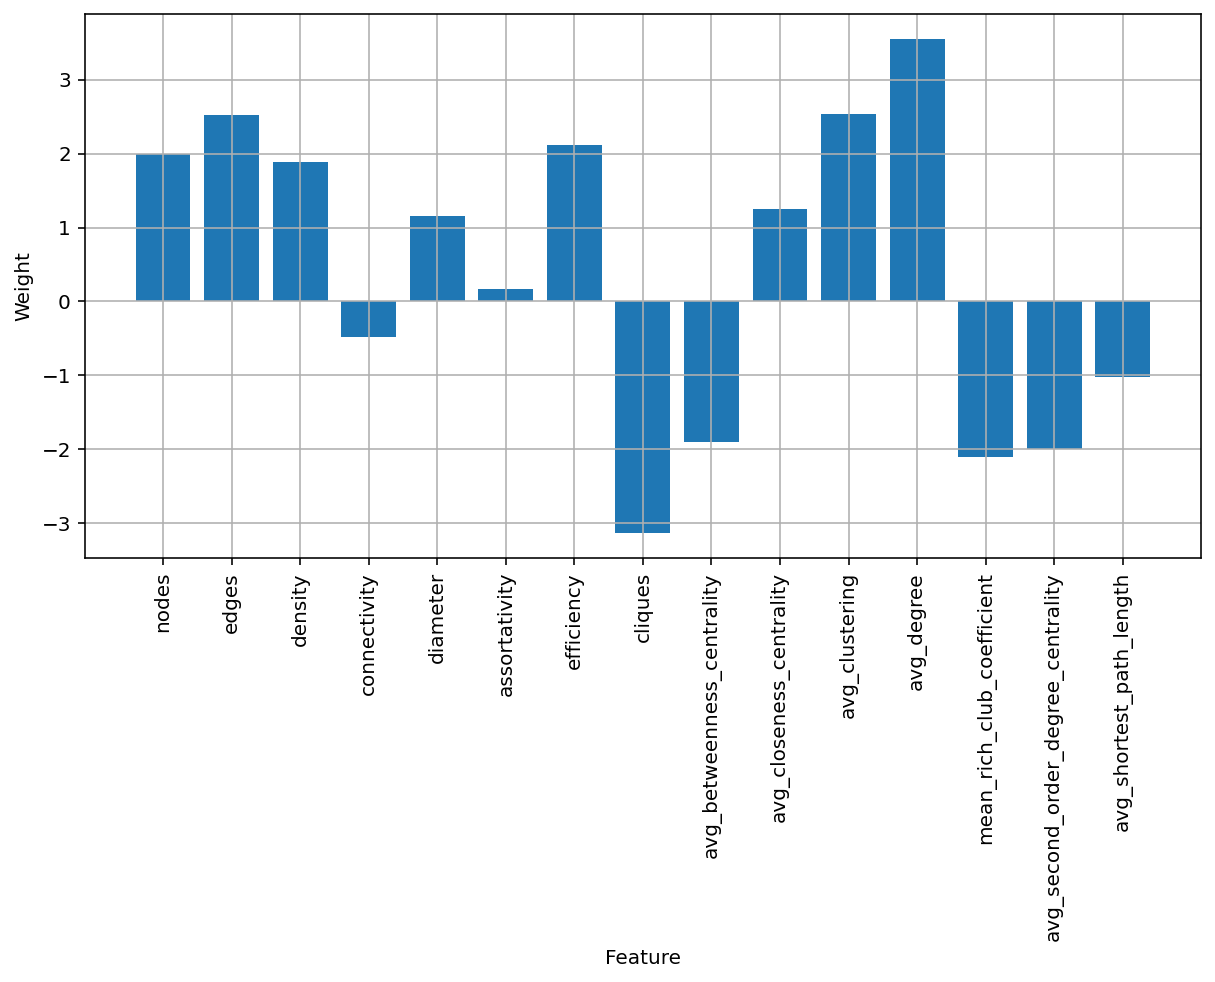

In [7]:
outcome_map = {
    'good' : 1,
    'bad' : 0,
}

X = np.array(stats.drop('outcome', axis=1).values)
Y = stats['outcome'].map(outcome_map).values
names = stats.columns[1:]


# Construct a linear model and optimize with lasso regularization
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression


# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# model = Lasso(alpha=0., max_iter=100000, tol=1e-15)
# model = LinearRegression(positive=True)
model = LogisticRegression(penalty='none', solver='saga', C=3, max_iter=10000, tol=1e-4, random_state=42)
model.fit(X, Y)

# Print each outcome and its coefficient
res = pd.DataFrame({'outcome': Y, 'prediction': model.predict(X)}, index=[f'Ep {i+1}' for i in range(len(Y))])
if type(model) == LogisticRegression:
    res['confidence'] = np.max(model.predict_proba(X), axis=1)
print(res)
color = '\033[92m' if all((np.array(res['outcome']) > 0) == (np.array(res['prediction']) > 0)) else '\033[91m'
print(f'{color}Score: {model.score(X, Y)}')

# Plot the coefficients
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(names, model.coef_[0] if type(model) == LogisticRegression else model.coef_)
ax.set_xlabel('Feature')
ax.set_ylabel('Weight')
ax.set_xticklabels(names, rotation=90)
ax.grid()
plt.show()

In [8]:
ranks = []

def remove_confidence(G_, node):
    G = G_.copy()
    G.remove_node(node)
    G = nx.subgraph(G, max(nx.connected_components(G), key=len))
    remove_stats = pd.DataFrame()
    for stat, value in get_stats(G).items():
        remove_stats.loc[i+1, f'{stat}'] = value
    remove_stats = remove_stats.reindex(columns=sorted([c for c in remove_stats.columns], key=lambda x: '_'.join(x.split('_')[1:])))
    remove_stats = remove_stats.fillna(0)
    X = np.array(remove_stats.values)
    X = scaler.transform(X)
    return model.predict_proba(X)[0][1]



for i, G in tqdm(enumerate(networks), total=len(networks)):
    rank = {}
    base_confidence = model.predict_proba(scaler.transform([stats.iloc[i].values[1:]]))[0][1]
    node_confidence_importance = []
    for node in G.nodes:
        confidence = remove_confidence(G, node)
        node_confidence_importance.append((node, base_confidence - confidence))
    rank['confidence'] = sorted(node_confidence_importance, key=lambda x: x[1], reverse=True)

    ranks.append(rank)

  0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
for G, R in tqdm(zip(networks, ranks), total=len(networks)):
    R['degree'] = sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)
    R['eigenvector'] = sorted(nx.eigenvector_centrality(G).items(), key=lambda x: x[1], reverse=True)
    R['betweenness'] = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
    R['closeness'] = sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)
    R['second_order'] = sorted(nx.second_order_centrality(G).items(), key=lambda x: x[1], reverse=True)
    # Average neighbor degree
    R['avg_neighbor_degree'] = sorted(nx.average_neighbor_degree(G).items(), key=lambda x: x[1], reverse=True)
    # Information centrality
    R['information'] = sorted(nx.information_centrality(G).items(), key=lambda x: x[1], reverse=True)
    # Load centrality
    R['load'] = sorted(nx.load_centrality(G).items(), key=lambda x: x[1], reverse=True)
    # Harmonic centrality
    R['harmonic'] = sorted(nx.harmonic_centrality(G).items(), key=lambda x: x[1], reverse=True)
    # Clustering coefficient
    R['clustering'] = sorted(nx.clustering(G).items(), key=lambda x: x[1], reverse=True)
    # Eccentricity
    R['eccentricity'] = sorted(nx.eccentricity(G).items(), key=lambda x: x[1], reverse=True)
    # PageRank
    R['pagerank'] = sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)
    # HITS
    hits = nx.hits(G)
    R['hits_hubs'] = sorted(hits[0].items(), key=lambda x: x[1], reverse=True)
    R['hits_authorities'] = sorted(hits[1].items(), key=lambda x: x[1], reverse=True)
    # Rich club coefficient
    # R['rich_club'] = sorted(nx.rich_club_coefficient(G, normalized=False).items(), key=lambda x: x[1], reverse=True)
    # Effective size
    R['effective_size'] = sorted(nx.effective_size(G).items(), key=lambda x: x[1], reverse=True)
    # Constraint
    R['constraint'] = sorted(nx.constraint(G).items(), key=lambda x: x[1], reverse=True)
    # Vitality
    R['vitality'] = sorted(nx.closeness_vitality(G).items(), key=lambda x: x[1], reverse=True)


  0%|          | 0/7 [00:00<?, ?it/s]

<class 'networkx.utils.decorators.argmap'> compilation 49:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/Users/mike/.pyenv/versions/3.10.2/envs/dev/lib/python3.10/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [10]:
# Compute the Kendall's tau and Spearman's rho correlation between the ranks and the confidence

from scipy.stats import kendalltau, spearmanr

correlations = [pd.DataFrame(columns=['Kendall\'s tau', 'Spearman\'s rho', 'p-value tau', 'p-value rho']) for i in range(len(networks))]

for i, ep_ranks in tqdm(enumerate(ranks), total=len(ranks)):
    for rank_name, rank in [r for r in ep_ranks.items() if r[0] != 'confidence']:
        try:
            tau, p_tau = kendalltau([r[0] for r in rank], [r[0] for r in ep_ranks['confidence']], method='exact')
            rho, p_rho = spearmanr([r[0] for r in rank], [r[0] for r in ep_ranks['confidence']])
            correlations[i].loc[rank_name] = [tau, rho, p_tau, p_rho]
        except:
            print(rank)
            raise ValueError(f'Error computing correlation for {rank_name} in episode {i}')
    # Sort bu p-value rho
    correlations[i] = correlations[i].sort_values(by='p-value rho')
    # Drop all columns that contain 'tau'
    correlations[i] = correlations[i][[c for c in correlations[i].columns if 'tau' not in c]]

  0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
for i, c in enumerate(correlations):
    print(f'Episode {i+1}')
    relevant = c[c['p-value rho'] <= 0.06]
    if len(relevant) < 3:
        # Take the 3 most relevant
        relevant = c.head(3)
    print(relevant)
    print('=========================')
    print()
    print()


Episode 1
                  Spearman's rho  p-value rho
closeness               0.251541     0.133145
second_order           -0.209104     0.214215
hits_authorities        0.167141     0.322780


Episode 2
              Spearman's rho  p-value rho
pagerank            0.369868     0.037198
second_order        0.271994     0.132074
constraint         -0.259531     0.151449


Episode 3
                Spearman's rho  p-value rho
vitality              0.289565     0.169920
effective_size        0.232174     0.274965
betweenness           0.226087     0.288100


Episode 4
              Spearman's rho   p-value rho
vitality           -0.884416  1.038294e-07
information        -0.462338  3.483880e-02
eccentricity        0.454545  3.843943e-02


Episode 5
                  Spearman's rho  p-value rho
eccentricity           -0.422078     0.056659
hits_authorities        0.323377     0.152742
hits_hubs               0.323377     0.152742


Episode 6
            Spearman's rho  p-value rho
closen

In [13]:
movies = pd.read_pickle('data/kaggle/credits_movie.pkl')

episode_to_titleId = ['tt0120915', 'tt0121765', 'tt0121766', 'tt0076759', 'tt0080684', 'tt0086190', 'tt2488496']
episode_dates = [movies[movies['imdb_id'] == id]['release_date'].values[0] for id in episode_to_titleId]

movie_net = pd.read_pickle('data/kaggle/nets/full.gpickle')

In [14]:
from functools import partial

episode_networks = []
for i, date in enumerate(episode_dates):
    ep_net = nx.subgraph_view(
        movie_net,
        filter_node=partial(lambda x, g, d: g.nodes[x]['date'] <= d, g=movie_net, d=date),
        filter_edge=partial(lambda x,y, g, d: g.edges[x,y]['date'] <= d, g=movie_net, d=date)
    )
    episode_networks.append(ep_net)

In [70]:
roman = {1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V', 6: 'VI', 7: 'VII'}

for i, ep_n in enumerate(episode_networks):
    print(f'{roman[i+1]} &', ' & '.join([
        str(num_nodes:=len(ep_n.nodes)),
        str(len(ep_n.edges)),
        str(np.mean(degs:=[d for n, d in tqdm(ep_n.degree(), total=num_nodes)])),
        str(np.max(degs)),
    ]), '\\\\\\hline')

  0%|          | 0/91148 [00:00<?, ?it/s]

I & 91148 & 2719475 & 59.67163294861105 & 3371 \\\hline


  0%|          | 0/102775 [00:00<?, ?it/s]

II & 102775 & 3042650 & 59.209924592556554 & 3371 \\\hline


  0%|          | 0/115460 [00:00<?, ?it/s]

III & 115460 & 3393442 & 58.781257578382125 & 3371 \\\hline


  0%|          | 0/42886 [00:00<?, ?it/s]

IV & 42886 & 1482587 & 69.14083850207527 & 3371 \\\hline


  0%|          | 0/47412 [00:00<?, ?it/s]

V & 47412 & 1582116 & 66.73905340420147 & 3371 \\\hline


  0%|          | 0/53534 [00:00<?, ?it/s]

VI & 53534 & 1725509 & 64.46404154369186 & 3371 \\\hline


  0%|          | 0/187450 [00:00<?, ?it/s]

VII & 187450 & 5626091 & 60.02764470525474 & 3371 \\\hline


In [71]:
# get the node with the highest degree
max(G.degree, key=lambda x: x[1])

((121323, 'Bess Flowers'), 3371)

  0%|          | 0/91148 [00:00<?, ?it/s]

  0%|          | 0/102775 [00:00<?, ?it/s]

  0%|          | 0/115460 [00:00<?, ?it/s]

  0%|          | 0/42886 [00:00<?, ?it/s]

  0%|          | 0/47412 [00:00<?, ?it/s]

  0%|          | 0/53534 [00:00<?, ?it/s]

  0%|          | 0/187450 [00:00<?, ?it/s]

/var/folders/l_/vnq08k4n0hn498fyp2mcvcsm0000gn/T/ipykernel_43932/3110237965.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


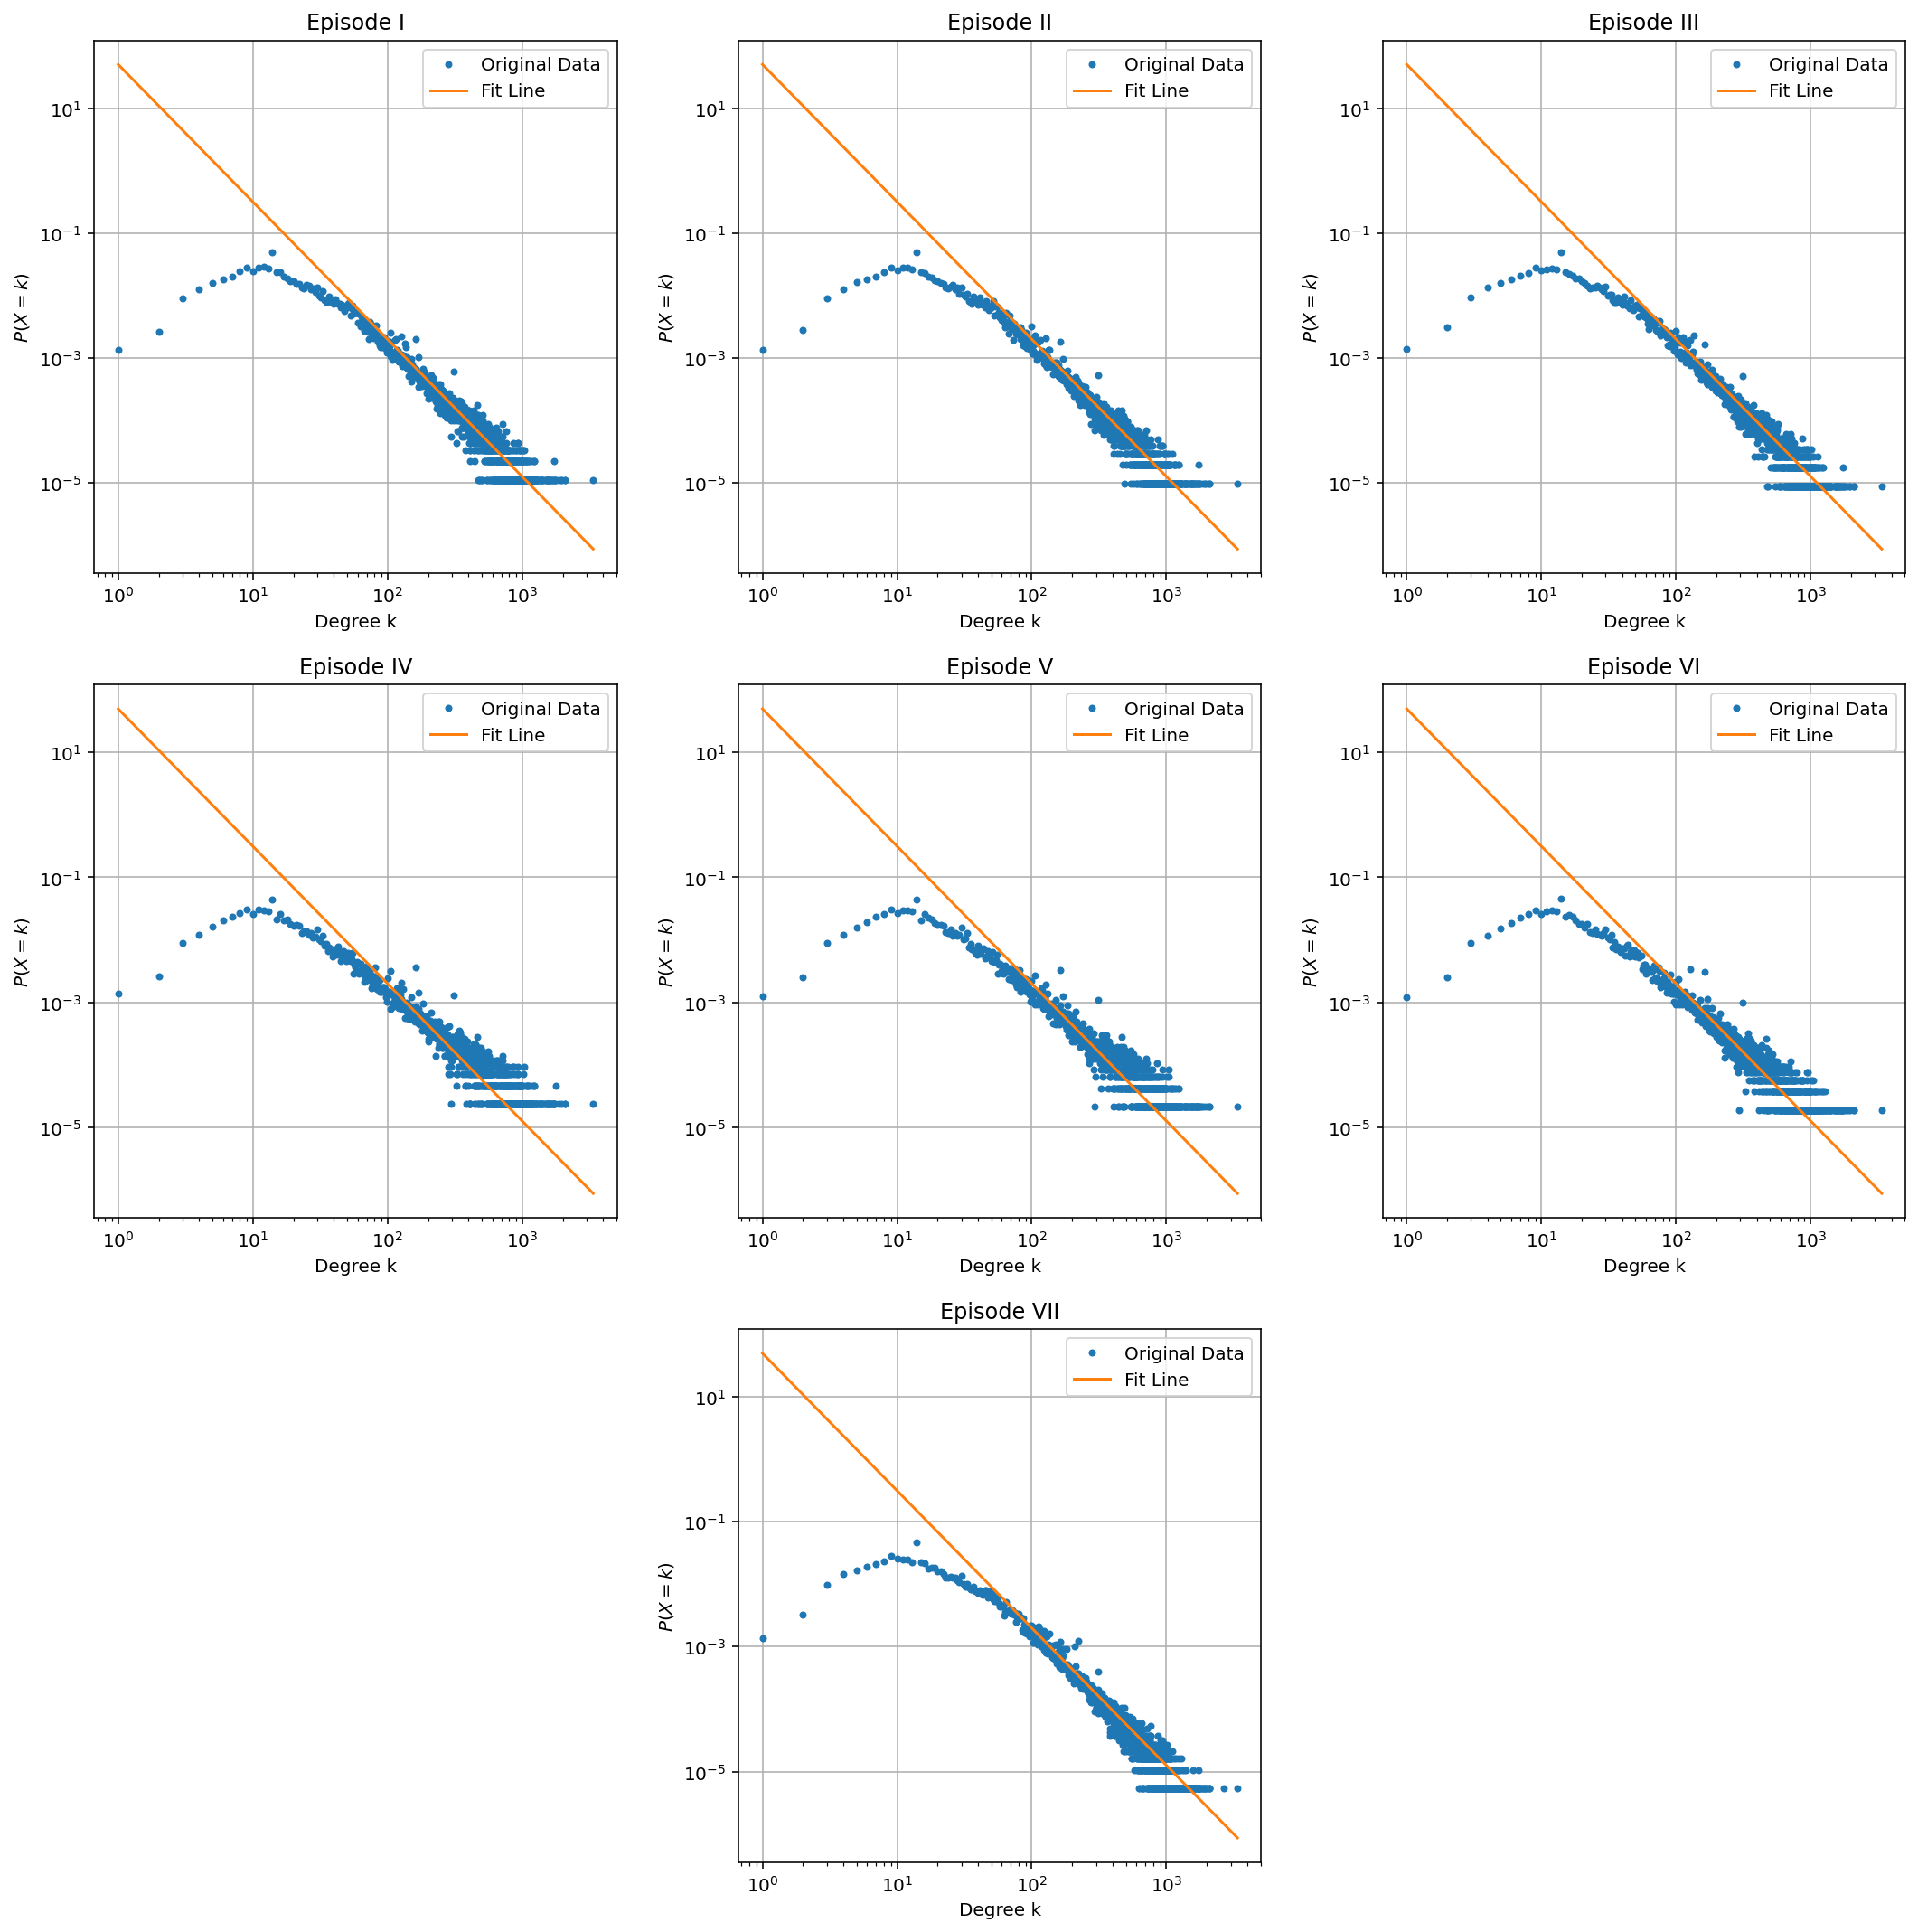

In [79]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

for i, ep_n in enumerate(episode_networks):
    degree_df = np.unique(sorted([d for _, d in tqdm(ep_n.degree(), total=len(ep_n))]), return_counts=True)
    sum_deg = np.sum(degree_df[1])
    ax_i = i if i < 6 else 7
    ax[ax_i].loglog(degree_df[0], degree_df[1] / sum_deg, '.', label='Original Data')
    ax[ax_i].loglog(degree_df[0], 5e1 / degree_df[0]**2.2, label='Fit Line')
    ax[ax_i].set_xlabel('Degree k')
    ax[ax_i].set_ylabel('$P(X=k)$')
    ax[ax_i].set_title(f'Episode {roman[i+1]}')
    ax[ax_i].legend()
    ax[ax_i].grid()

fig.tight_layout()
fig.delaxes(ax[6])
fig.delaxes(ax[8])

fig.show()

In [22]:
metric = 'closeness'
keep_old_ranks = True

def get_ranking(episode, G):
    movie_ep = movies[movies.imdb_id == episode_to_titleId[episode]]
    characters = {c['character']: (c['id'], c['name']) for c in movie_ep.cast.values[0]}

    episode_characters = {k:characters[v] for k,v in name_mappings[episode].items() if v in characters}

    base_rank = [r for r in ranks[episode][metric] if r[0] in episode_characters]

    movie_rank_closeness = sorted([(k, nx.closeness_centrality(G, u=v)) for k,v in tqdm(episode_characters.items(), total=len(episode_characters), leave=True, desc=f'Ep {episode+1}')], key=lambda x: x[1], reverse=True)

    return base_rank, movie_rank_closeness, episode



from concurrent.futures import ThreadPoolExecutor

movie_rank_futures = []
with ThreadPoolExecutor(max_workers=7) as executor:
    for episode, G in enumerate(episode_networks):
        movie_rank_futures.append(executor.submit(get_ranking, episode, G))
movie_rank_results = sorted([f.result() for f in movie_rank_futures], key=lambda x: x[-1])

if not keep_old_ranks:
    movie_ranks = []
    for i, (base_rank, movie_rank) in enumerate(movie_rank_results):
        movie_ranks.append({
            'base_rank': base_rank,
            metric: movie_rank
        })
else:
    for i, (base_rank, movie_rank) in enumerate(movie_rank_results):
        movie_ranks[i][metric] = movie_rank

Ep 2:   0%|          | 0/28 [00:00<?, ?it/s]

Ep 1:   0%|          | 0/34 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/21 [00:00<?, ?it/s]

Ep 6:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 7:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 4:   0%|          | 0/18 [00:00<?, ?it/s]

Ep 5:   0%|          | 0/21 [00:00<?, ?it/s]

In [58]:
def get_correlation(rank, base, metric):
    tau_c, p_tau_c = kendalltau([r[0] for r in rank], [r[0] for r in base], method='exact')
    rho_c, p_rho_c = spearmanr([r[0] for r in rank], [r[0] for r in base])

    return pd.DataFrame({
        f'Spearman\'s rho {metric}': [rho_c],
        f'p-value rho {metric}': [p_rho_c],
        f'Kendall\'s tau {metric}': [tau_c],
        f'p-value tau {metric}': [p_tau_c],
    })

correlations = []
for rank in movie_ranks:
    correlations.append(get_correlation(rank[metric], rank['base'], metric))

In [59]:
# Merge the correlations and name each episode
pd.concat(correlations, keys=[f'Episode {i+1}' for i in range(len(correlations))])

,,Spearman's rho closeness,p-value rho closeness,Kendall's tau closeness,p-value tau closeness
Episode 1,0,-0.178304,0.313019,-0.115865,0.345439
Episode 2,0,0.372742,0.050761,0.227513,0.093256
Episode 3,0,0.036364,0.875650,0.028571,0.881508
Episode 4,0,-0.434469,0.071597,-0.281046,0.112418
Episode 5,0,0.250649,0.273124,0.161905,0.323209
Episode 6,0,-0.009023,0.969885,0.010526,0.974467
Episode 7,0,0.118632,0.563802,0.107692,0.457440


In [64]:
for i, r in enumerate(ranks):
    print(f'Episode {i+1}', [c[0] for c in r[metric][:5]])

Episode 1 ['QUI-GON', 'PADME', 'ANAKIN', 'JAR JAR', 'OBI-WAN']
Episode 2 ['ANAKIN', 'OBI-WAN', 'PADME', 'MACE WINDU', 'YODA']
Episode 3 ['ANAKIN', 'OBI-WAN', 'BAIL ORGANA', 'EMPEROR', 'C-3PO']
Episode 4 ['LUKE', 'LEIA', 'C-3PO', 'R2-D2', 'HAN']
Episode 5 ['LUKE', 'HAN', 'DARTH VADER', 'LEIA', 'C-3PO']
Episode 6 ['LUKE', 'C-3PO', 'HAN', 'LEIA', 'LANDO']
Episode 7 ['POE', 'FINN', 'HAN', 'CHEWBACCA', 'KYLO REN']


In [63]:
for i, r in enumerate(movie_ranks):
    movie_ep = movies[movies.imdb_id == episode_to_titleId[i]]
    characters = {c['character']: (c['id'], c['name']) for c in movie_ep.cast.values[0]}
    episode_characters = {k:characters[v] for k,v in name_mappings[i].items() if v in characters}
    print(f'Episode {i+1}', [(c[0],episode_characters[c[0]][1]) for c in r[metric][:5]])

Episode 1 [('MACE WINDU', 'Samuel L. Jackson'), ('VALORUM', 'Terence Stamp'), ('QUI-GON', 'Liam Neeson'), ('YODA', 'Frank Oz'), ('BOSS NASS', 'Brian Blessed')]
Episode 2 [('COUNT DOOKU', 'Christopher Lee'), ('MACE WINDU', 'Samuel L. Jackson'), ('YODA', 'Frank Oz'), ('CLIEGG', 'Jack Thompson'), ('PADME', 'Natalie Portman')]
Episode 3 [('COUNT DOOKU', 'Christopher Lee'), ('DARTH VADER', 'James Earl Jones'), ('MACE WINDU', 'Samuel L. Jackson'), ('YODA', 'Frank Oz'), ('PADME', 'Natalie Portman')]
Episode 4 [('TARKIN', 'Peter Cushing'), ('OBI-WAN', 'Alec Guinness'), ('OWEN', 'Phil Brown'), ('DARTH VADER', 'James Earl Jones'), ('HAN', 'Harrison Ford')]
Episode 5 [('OBI-WAN', 'Alec Guinness'), ('DARTH VADER', 'James Earl Jones'), ('DERLIN', 'John Ratzenberger'), ('EMPEROR', 'Clive Revill'), ('HAN', 'Harrison Ford')]
Episode 6 [('OBI-WAN', 'Alec Guinness'), ('DARTH VADER', 'James Earl Jones'), ('HAN', 'Harrison Ford'), ('PIETT', 'Kenneth Colley'), ('LANDO', 'Billy Dee Williams')]
Episode 7 [('

In [61]:
corr = pd.DataFrame()

for i, r in enumerate(movie_ranks):
    top_n = 5
    base_rank = r['base'][:top_n]
    movie_rank = r[metric][:top_n]
    rho_c, p_rho_c = spearmanr([r[0] for r in movie_rank], [r[0] for r in base_rank])
    tau_c, p_tau_c = kendalltau([r[0] for r in movie_rank], [r[0] for r in base_rank], method='exact')
    corr.loc[f'Episode {i+1}', f'Spearman\'s rho {metric}'] = rho_c
    corr.loc[f'Episode {i+1}', f'p-value rho {metric}'] = p_rho_c
    corr.loc[f'Episode {i+1}', f'Kendall\'s tau {metric}'] = tau_c
    corr.loc[f'Episode {i+1}', f'p-value tau {metric}'] = p_tau_c

corr

,Spearman's rho closeness,p-value rho closeness,Kendall's tau closeness,p-value tau closeness
Episode 1,-0.3,0.623838,-0.2,0.816667
Episode 2,0.8,0.104088,0.6,0.233333
Episode 3,0.4,0.504632,0.4,0.483333
Episode 4,-0.3,0.623838,-0.2,0.816667
Episode 5,0.3,0.623838,0.2,0.816667
Episode 6,0.9,0.037386,0.8,0.083333
Episode 7,-0.1,0.872889,0.0,1.000000
